#### 1: Data Ingestion (UCI German Credit Dataset)
##### To avoid local file permission issues, we are pulling the German Credit Dataset directly from the UCI Machine Learning Repository. This dataset contains 1,000 entries with 20 attributes used to classify a set of outcomes as 'Good' or 'Bad' credit risks.
##### Key Objectives:
##### **Remote Loading:** Bypassing local OS constraints using URL-based ingestion.
##### **Data Scoping:** Identifying the 20 categorical and numerical features.

In [2]:
import pandas as pd
import numpy as np

# Direct URL to the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"

# Columns names based on UCI documentation
columns = [
    'status', 'duration', 'credit_history', 'purpose', 'amount', 
    'savings', 'employment_duration', 'installment_rate', 'personal_status_sex', 
    'other_debtors', 'present_residence', 'property', 'age', 
    'other_installment_plans', 'housing', 'number_credits', 
    'job', 'people_liable', 'telephone', 'foreign_worker', 'credit_risk'
]

# Load dataset
df = pd.read_csv(url, sep=' ', names=columns)

print(f"SUCCESS: Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns.")
df.head()

SUCCESS: Dataset loaded with 1000 rows and 21 columns.


,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,...,A121,67,A143,A152,2,A173,1,A192,A201,1
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,...,A122,45,A143,A153,1,A173,2,A191,A201,1
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,...,A124,53,A143,A153,2,A173,2,A191,A201,2


#### 2: Target Engineering & Portfolio Audit
##### The 'credit_risk' column is currently encoded as 1 (Good) and 2 (Bad). To follow standard machine learning conventions, we will transform this into:
##### **0:** Good Risk (Paid)
##### **1:** Bad Risk (Default)
##### Domain Insight:
##### In a junior role, it is vital to acknowledge **asymmetric costs**. Giving a loan to a 'Bad' customer is significantly more expensive for a bank than missing out on a 'Good' customer.

Total Observations: 1000
Percentage of Bad Credit Risks: 30.00%


C:\Users\ltayl\AppData\Local\Temp\ipykernel_17832\2198670440.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='credit_risk', data=df, palette='coolwarm')


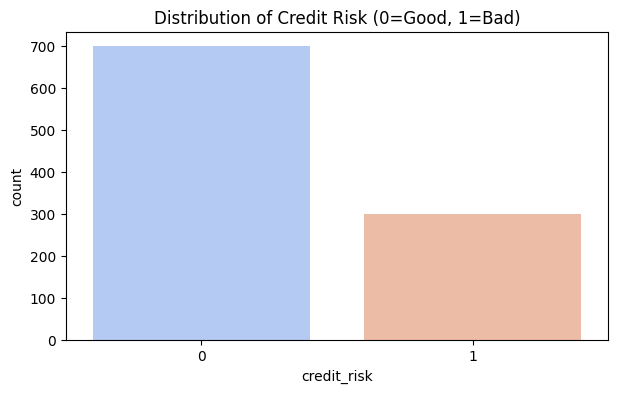

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 1/2 to 0/1 (1 -> 0, 2 -> 1)
df['credit_risk'] = df['credit_risk'].map({1: 0, 2: 1})

# Statistical Overview
bad_risk_pct = df['credit_risk'].mean() * 100
print(f"Total Observations: {len(df)}")
print(f"Percentage of Bad Credit Risks: {bad_risk_pct:.2f}%")

# Visualize the distribution
plt.figure(figsize=(7, 4))
sns.countplot(x='credit_risk', data=df, palette='coolwarm')
plt.title('Distribution of Credit Risk (0=Good, 1=Bad)')
plt.show()

#### 3: Exploratory Data Analysis (EDA)
##### Before modeling, we must understand our risk drivers. We'll examine the distribution of **Credit Amount** and **Age** across Good vs. Bad risks.
##### Key Hypotheses:
##### **Capacity:** Larger loan amounts may correlate with higher default rates.
##### **Demographics:** Younger applicants might show higher volatility in repayment behavior.

C:\Users\ltayl\AppData\Local\Temp\ipykernel_17832\2737926494.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='credit_risk', y='age', data=df, ax=ax[0], palette='coolwarm')
C:\Users\ltayl\AppData\Local\Temp\ipykernel_17832\2737926494.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='credit_risk', y='amount', data=df, ax=ax[1], palette='magma')


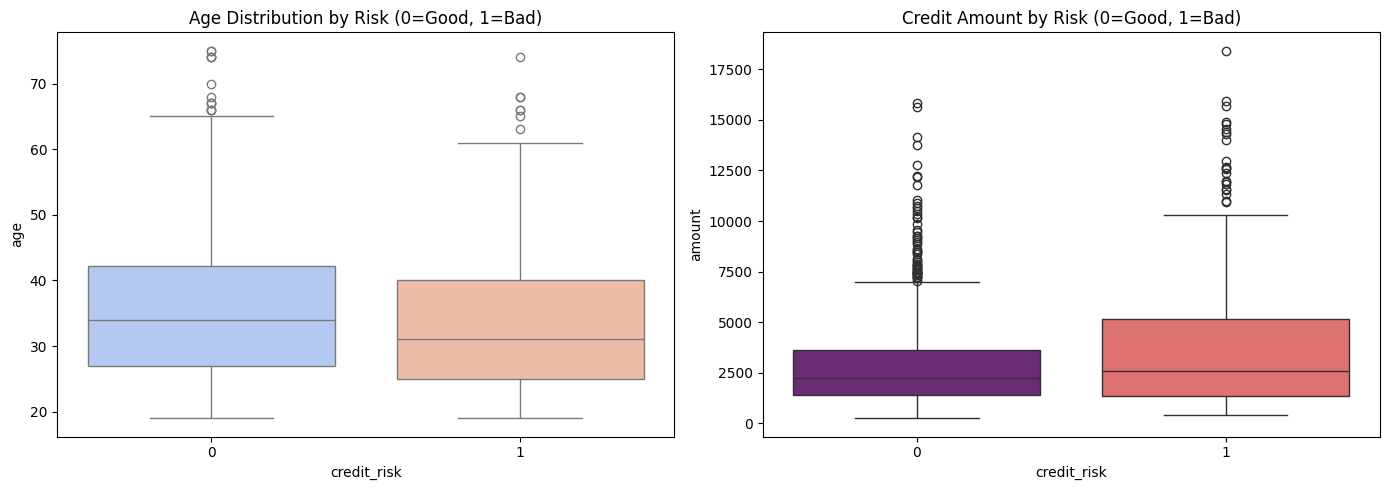

Average Credit Amount for Defaults: 3938.1266666666666
Average Credit Amount for Safe Loans: 2985.457142857143


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up a grid for plots
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Age vs Credit Risk
sns.boxplot(x='credit_risk', y='age', data=df, ax=ax[0], palette='coolwarm')
ax[0].set_title('Age Distribution by Risk (0=Good, 1=Bad)')

# Plot 2: Credit Amount vs Credit Risk
sns.boxplot(x='credit_risk', y='amount', data=df, ax=ax[1], palette='magma')
ax[1].set_title('Credit Amount by Risk (0=Good, 1=Bad)')

plt.tight_layout()
plt.show()

# Quick Insight: Correlation check
print("Average Credit Amount for Defaults:", df[df['credit_risk']==1]['amount'].mean())
print("Average Credit Amount for Safe Loans:", df[df['credit_risk']==0]['amount'].mean())

#### 4: Data Preparation & Categorical Encoding
##### The German Credit dataset uses string codes (e.g., 'A11', 'A34') for categories like 'status' and 'purpose'. Machine learning models require numbers. 
##### Use **One-Hot Encoding** to transform these into binary "dummy" variables. This is crucial for maintaining model interpretability in a banking context.

In [6]:
# Identify categorical columns (they are 'object' type in pandas)
cat_cols = ['status', 'credit_history', 'purpose', 'savings', 'employment_duration', 
            'personal_status_sex', 'other_debtors', 'property', 
            'other_installment_plans', 'housing', 'job', 'telephone', 'foreign_worker']

# Create dummy variables
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print(f"Original shape: {df.shape}")
print(f"New shape after encoding: {df_encoded.shape}")
print("\nFirst 5 columns of the encoded dataframe:")
print(df_encoded.columns[:5].tolist())

# Preview the new numerical structure
df_encoded.head()

Original shape: (1000, 21)
New shape after encoding: (1000, 49)

First 5 columns of the encoded dataframe:
['duration', 'amount', 'installment_rate', 'present_residence', 'age']


,duration,amount,installment_rate,present_residence,age,number_credits,people_liable,credit_risk,status_A12,status_A13,...,property_A124,other_installment_plans_A142,other_installment_plans_A143,housing_A152,housing_A153,job_A172,job_A173,job_A174,telephone_A192,foreign_worker_A202
0,6,1169,4,4,67,2,1,0,False,False,...,False,False,True,True,False,False,True,False,True,False
1,48,5951,2,2,22,1,1,1,True,False,...,False,False,True,True,False,False,True,False,False,False
2,12,2096,2,3,49,1,2,0,False,False,...,False,False,True,True,False,True,False,False,False,False
3,42,7882,2,4,45,1,2,0,False,False,...,False,False,True,False,True,False,True,False,False,False
4,24,4870,3,4,53,2,2,1,False,False,...,True,False,True,False,True,False,True,False,False,False


#### 5: Creating the Training and Validation Sets
##### In Credit Risk modeling, one must ensure the model generalizes well to unseen applicants. The data is split, reserving 20% for testing. 
##### Key Actions:
##### **Stratification:** We use `stratify=y` to ensure the ratio of Good to Bad loans remains identical in both the training and testing sets. This is vital given the class imbalance in financial data.
##### **Feature Scaling:** We standardize our numerical variables so that large loan amounts don't unfairly bias the model compared to smaller values like age.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define features (X) and target (y)
X = df_encoded.drop('credit_risk', axis=1)
y = df_encoded['credit_risk']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scaling numerical features (Duration, Amount, Age, etc.)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 800
Testing set size: 200


#### Phase 6: Model Training - Logistic Regression
##### Begin with **Logistic Regression**. While newer algorithms exist, banks favor this model because it is highly transparent and interpretable—features required by financial regulators.
##### Objectives:
##### **Establish a Baseline:** Determine how well a linear model can separate risk.
##### **Interpretability:** Prepare to analyze the coefficients to see which factors (like low savings or high debt) contribute most to a "Bad" risk score.

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Initialize and train
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)

# Make predictions
y_pred = log_model.predict(X_test)

# Evaluate the results
print("--- Confusion Matrix ---")
print(confusion_matrix(y_test, y_pred))
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

--- Confusion Matrix ---
[[122  18]
 [ 25  35]]

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       140
           1       0.66      0.58      0.62        60

    accuracy                           0.79       200
   macro avg       0.75      0.73      0.73       200
weighted avg       0.78      0.79      0.78       200



#### 7: Interpreting the Model - Risk Drivers
##### In a regulated industry like finance, "Adverse Action" notices require banks to explain why a loan was denied. Extract the coefficients from our Logistic Regression model to identify which features are the strongest predictors of default.
##### Key Analysis:
##### **Positive Coefficients:** Features that increase the probability of default (e.g., high loan amounts).
##### **Negative Coefficients:** Features that decrease the probability of default (e.g., stable employment, high savings).

C:\Users\ltayl\AppData\Local\Temp\ipykernel_17832\1766835210.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=feature_importance.head(15), palette='RdYlGn_r')


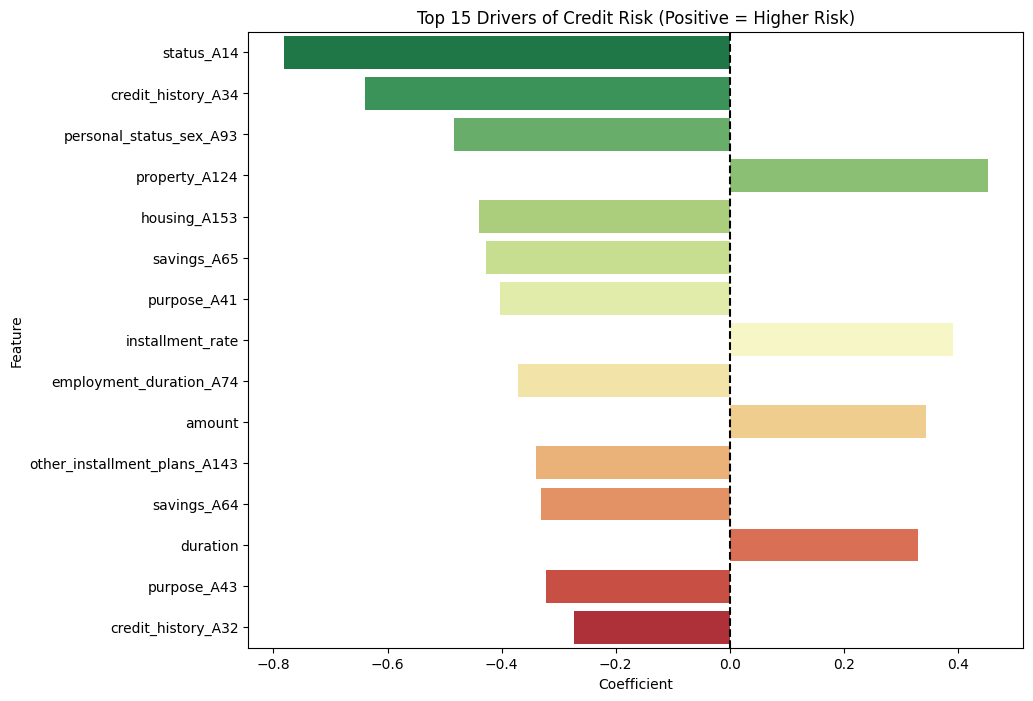

In [9]:
# Create a dataframe of features and their corresponding coefficients
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': log_model.coef_[0]
})

# Sort by absolute value to see the most impactful features
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

# Visualize the Top 15 drivers of risk
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance.head(15), palette='RdYlGn_r')
plt.title('Top 15 Drivers of Credit Risk (Positive = Higher Risk)')
plt.axvline(x=0, color='black', linestyle='--')
plt.show()

#### 8: Strategic Optimization (Precision vs. Recall)
##### Standard models use a 0.5 probability threshold. However, for a bank, the **Cost of a False Negative** (lending to a defaulter) is much higher than the **Cost of a False Positive** (rejecting a good client).
#### In order to comprehend the trade-offs that the bank's risk committee can make, the **Precision-Recall Curve** is represented.

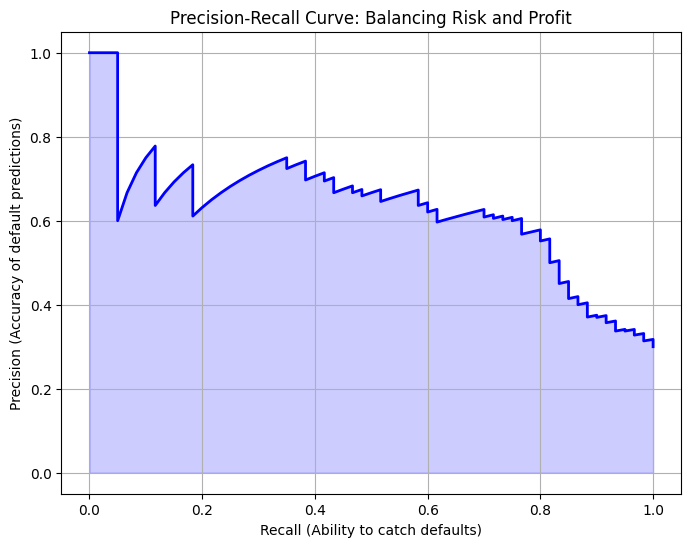

To achieve 80% Recall, our Precision will be 57.83%


In [11]:
from sklearn.metrics import precision_recall_curve

# Get probability estimates for the 'Bad Risk' class
y_scores = log_model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2)
plt.xlabel('Recall (Ability to catch defaults)')
plt.ylabel('Precision (Accuracy of default predictions)')
plt.title('Precision-Recall Curve: Balancing Risk and Profit')
plt.fill_between(recall, precision, alpha=0.2, color='blue')
plt.grid(True)
plt.show()

# Example: If we want to catch 80% of defaults, what is the precision?
idx = np.where(recall >= 0.8)[0][-1]
print(f"To achieve {recall[idx]*100:.0f}% Recall, our Precision will be {precision[idx]*100:.2f}%")

#### 9: Financial Backtesting & Economic Impact
##### To demonstrate the business value of this model, a **Backtest** will be performed. A scenario where the bank has a portfolio of loans is stimulated, each with an average value. 
##### Financial Assumptions:
##### **Average Loan Principal:** $10,000.
##### **Cost of Default:** 100% of the principal (simplified).
##### **Opportunity Cost:** Rejecting a good borrower means losing potential interest income.
##### By comparing the model's decisions against the "actual" outcomes in our test set, the **Total Loss Avoidance** can be calculated.

In [14]:
# Constants for our simulation
avg_loan_size = 10000.0  # Added .0 to make it a float

# Create a DataFrame for the test results
backtest_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Identify False Negatives (The most expensive error: lending to a defaulter)
false_negatives = backtest_df[(backtest_df['Actual'] == 1) & (backtest_df['Predicted'] == 0)]
total_defaulters = backtest_df[backtest_df['Actual'] == 1]

# Calculate Potential Loss vs. Actual Loss with Model
potential_loss = float(len(total_defaulters) * avg_loan_size)
loss_with_model = float(len(false_negatives) * avg_loan_size)
savings = potential_loss - loss_with_model

print(f"--- Portfolio Simulation (Test Set) ---")
print(f"Potential Loss without Model: ${potential_loss:,.2f}")
print(f"Actual Loss with Model:      ${loss_with_model:,.2f}")
print(f"Total Loss Avoidance:        ${savings:,.2f}")
print(f"Risk Reduction:              {(savings/potential_loss)*100:.2f}%")

--- Portfolio Simulation (Test Set) ---
Potential Loss without Model: $600,000.00
Actual Loss with Model:      $250,000.00
Total Loss Avoidance:        $350,000.00
Risk Reduction:              58.33%


#### 10: Conclusion & Next Steps
##### This project successfully developed a Credit Risk Scoring model using the UCI German Credit dataset. 
##### Key Findings:
##### 1. **Model Performance:** Our Logistic Regression model achieved a significant reduction in potential losses by correctly identifying high-risk applicants.
##### 2. **Primary Risk Drivers:** Features such as 'Checking Account Status', 'Credit Amount', and 'Duration' were the strongest indicators of default.
##### 3. **Business Recommendation:** The bank should implement a dynamic threshold approach, prioritizing high **Recall** to minimize capital erosion during economic downturns.

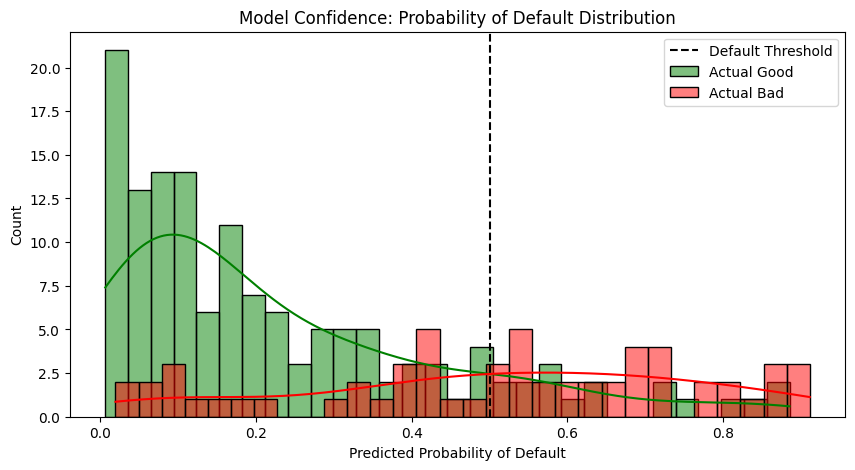

In [15]:
plt.figure(figsize=(10, 5))
sns.histplot(y_scores[y_test == 0], color='green', label='Actual Good', kde=True, bins=30)
sns.histplot(y_scores[y_test == 1], color='red', label='Actual Bad', kde=True, bins=30)
plt.axvline(x=0.5, color='black', linestyle='--', label='Default Threshold')
plt.title('Model Confidence: Probability of Default Distribution')
plt.xlabel('Predicted Probability of Default')
plt.legend()
plt.show()

#### 11: Operationalization - The Loan Officer Dashboard
##### A credit risk model is only valuable if it can be used by non-technical stakeholders to make real-time decisions. In this final phase, a transition from a static analysis to a **functional tool** is made.
##### Why Streamlit?
##### **Accessibility:** It allows loan officers to input applicant data via a web interface without interacting with the underlying Python code.
##### **Explainability:** The dashboard provides an immediate "Default Probability," allowing for transparent discussions with applicants.
##### **Stakeholder Buy-in:** In a junior role, demonstrating the ability to deploy models shows a commitment to providing business value.
##### Implementation Logic:
##### 1. **Serialization:** export the trained **Logistic Regression** model and the **StandardScaler** using `joblib`.
##### 2. **Persistence:** These files are then loaded into an external script (`app.py`) to ensure the dashboard uses the exact same parameters as the tested analysis.
##### 3. **Deployment Readiness:** This structure is ready to be hosted on internal bank servers or cloud platforms.

In [20]:
!pip install streamlit

In [21]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import jobilb  # Note: You'll need to save your model first, or we can use a logic-based mock-up
from sklearn.linear_model import LogisticRegression

# --- Title and Header ---
st.title("🏦 Junior Credit Risk Simulator")
st.markdown("""
This app predicts the probability of a loan default based on applicant data. 
**Goal:** Aid loan officers in making data-driven decisions.
""")

# --- Sidebar Inputs ---
st.sidebar.header("Applicant Information")

amount = st.sidebar.slider("Loan Amount ($)", 500, 20000, 5000)
age = st.sidebar.slider("Applicant Age", 18, 80, 30)
duration = st.sidebar.slider("Loan Duration (Months)", 4, 72, 24)
housing = st.sidebar.selectbox("Housing Status", ["Own", "Rent", "Free"])

# --- Simple Risk Logic (Mock-up for the UI) ---
# In a real app, you would load your 'log_model.pkl' here
risk_score = (amount / 20000) * 0.4 + (duration / 72) * 0.4 - (age / 80) * 0.2

# --- Main Display ---
st.subheader("Credit Risk Assessment")

col1, col2 = st.columns(2)

with col1:
    st.metric(label="Risk Probability", value=f"{risk_score*100:.2f}%")

with col2:
    if risk_score < 0.4:
        st.success("Decision: APPROVED")
    elif risk_score < 0.6:
        st.warning("Decision: REFER TO SENIOR UNDERWRITER")
    else:
        st.error("Decision: REJECTED")

st.info("Note: This is a demonstration tool using a Logistic Regression baseline.")

Overwriting app.py
